# Load Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from tensorflow.keras import applications
from tensorflow.keras import optimizers, losses ,layers, callbacks, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Loading 

## link to data
https://drive.google.com/file/d/176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D/view
or 
https://drive.google.com/uc?id=176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D&export=download

 Data Specs : 
 * Storage : 224Mo ( Folder Train( 5 classes), Test(910 pictures), CSV file of Test Data)


|____zip_file
     
     |_____train
               |______elefante_train
               |______farfalla_train
               |______mucca_train
               |______pecora_train
               |______scoiattolo_train
     |______test
     |______Testing_set_animals.csv
     

 

In [ ]:
# Data Directory 
DATADIR = os.listdir("./train")

## Reading the data and storing it into a dataframe


In [ ]:
# Reading the data and storing it into a dataframe
categories = []
files = []
i = 0

for k, folder in enumerate(DATADIR):
    filenames = os.listdir("./train/" + folder);
    for file in filenames:
        files.append("./train/" + folder + "/" + file)
        categories.append(k)

        # creating a dataframe of images and their respective categories        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

#initializing empty train df
train_df = pd.DataFrame(columns=['filename', 'category'])

#collecting 500 samples from each of 10 categories
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])


train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,./train/elefante_train/ea36b0072bfc063ed1584d0...,0
1,./train/elefante_train/ea36b0082bf2063ed1584d0...,0
2,./train/elefante_train/ea36b0082bf2083ed1584d0...,0
3,./train/elefante_train/ea36b10920f7093ed1584d0...,0
4,./train/elefante_train/ea36b10928f5023ed1584d0...,0
...,...,...
2495,./train/scoiattolo_train/OIP-g7fsz1ST2CbKuPs2z...,4
2496,./train/scoiattolo_train/OIP-g7JziEBCUsiuhsJta...,4
2497,./train/scoiattolo_train/OIP-gayTl9CatU8BaTaPt...,4
2498,./train/scoiattolo_train/OIP-gBCbQ2qnTkAta18ay...,4


## Shuffling input and target for optimum training

In [ ]:
# Shuffling input and target for optimum training
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

In [ ]:
# Function for Resizing and Reshaping the input images
def centering_image(img):
    
    size = [256,256]
    #shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
    #creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [ ]:
# Image Resizing and converting them to array
""" 
TQDM is a progress bar library. 
Inserting tqdm (or python -m tqdm)between pipes will pass 
through all stdin to stdout while printing progress to stderr
"""
images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        
        #read image
        img = cv2.imread(file_path,1)
        #color order is changed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)


In [ ]:
# Viewing Images after preprocessing

IndexError: index 1 is out of bounds for axis 0 with size 0

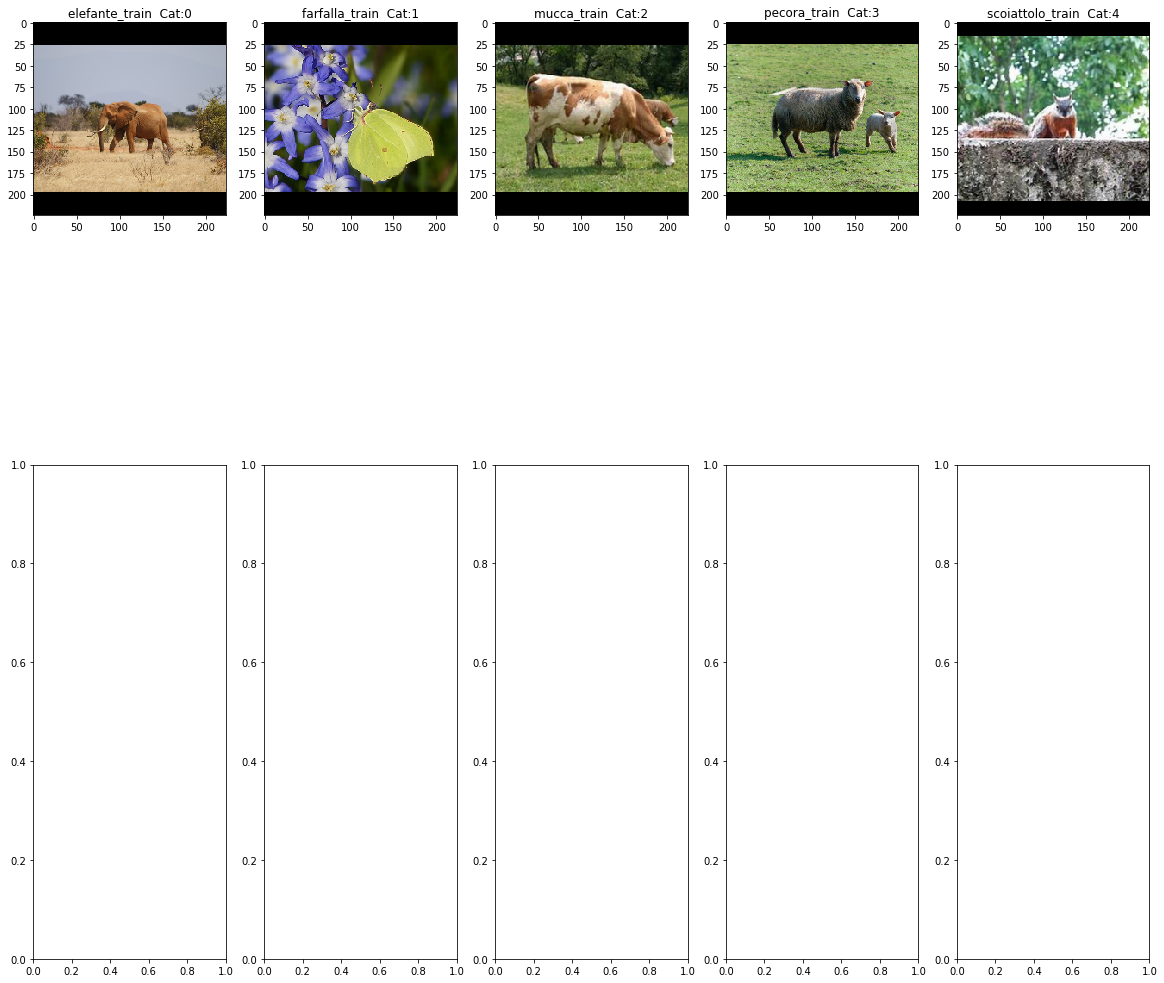

In [ ]:
cols=5
fig, ax = plt.subplots(2,5, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[1] #takes path in os of 1 value of figure of each category
    ax[i//cols, i%cols].set_title(path[0].split('/')[-2] +' '+' Cat:'+ str(path[1])) # -2 is location of name of figure in path
    ax[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [ ]:
# Re-Shuffling processed train data and converting to array
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

## Train val split, OneHotVectorizing categories, Input normalization

### Train val split

In [ ]:
#Train val split
val_split_num = int(round(0.2*len(y)))

x_train = x[val_split_num:]
y_train = y[val_split_num:]

x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('#########TRAIN###############')
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('#########TEST###############')
print('x_test', x_test.shape)
print('y_test', y_test.shape)
print('############################')

#########TRAIN###############
x_train (2000, 224, 224, 3)
y_train (2000,)
#########TEST###############
x_test (500, 224, 224, 3)
y_test (500,)
############################


### OneHotVectorizing 

In [ ]:
# OneHotVectorizing categories
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train[:5])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


### Normalization 

In [ ]:
# Input normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_train.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_train.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (2000, 224, 224, 3) 	 x_test Shape: (2000, 224, 224, 3)
y_train Shape:  (2000, 5) 	 y_test Shape: (2000, 5)
image Shape: (224, 224, 3)


### Renaming the 5 classes

In [ ]:
"""
Animals 5 classes
elefante = Elephant
farfalla = Batterfly
mucca = Cow
Pecora = Sheep
scoiattolo = Squirrel
"""

animal_names = [] 
for i in range(5):
    path = train_df[train_df.category == i].values[1]
    if path[0].split('/')[-2] == 'elefante_train':
        animal_names.append('elefante')
    elif path[0].split('/')[-2] == 'farfalla_train':
        animal_names.append('farfalla')
    elif path[0].split('/')[-2] == 'mucca_train':
        animal_names.append('mucca')
    elif path[0].split('/')[-2] == 'pecora_train':
        animal_names.append('pecora')
    elif path[0].split('/')[-2] == 'scoiattolo_train':
        animal_names.append('scoiattolo')
    
    

In [ ]:
len(animal_names)

5

### Preprocessing test data

In [ ]:
# Preprocessing test data

test_images = []
test_df = pd.DataFrame(columns=['filename'])
actual_pred=pd.DataFrame(columns=['Category'])
for i in range(10):
    test_df = test_df.append(df[df.category == i].iloc[500:502,:1])
    actual_pred=actual_pred.append(df[df.category == i].iloc[500:502,1:])

    test_df = test_df.reset_index(drop=True)
    actual_pred = actual_pred.reset_index(drop=True)
with tqdm(total=len(test_df)) as k:  
    for i, file_path in enumerate(test_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)
test_images = np.array(test_images).reshape(-1,224,224,3)

# Normalize test_images.
test_images = test_images/255

# Defining the Architecture of our Models Using ConvNets.

##  Now Let us define a suitable deep net. ( 2 VGG Block)


 * ConV filters = __16__ and then __32__
 * Kernel : (3,3)
 * Strides : (1,1)
 * Pool_size: (2,2)
 * Activation = __Relu__
 * Dropout : __30%__
 * Units : __256 Units__
 * output : __Softmax__ & __5__ classes.


In [ ]:
# Creating a 2 VGG block

rows,cols,channel = 224, 224, 3
# define input shape
INPUT_SHAPE = (224, 224, 3)
epochs = 20
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.9

sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

loss = losses.SparseCategoricalCrossentropy(
    from_logits=True,
    name='sparse_categorical_crossentropy')

In [ ]:
# define sequential model  With 2 CNN Layers
model = models.Sequential()


#input_layer = tf.keras.reshape(x_train, [-1, 28, 28, 3])

# define conv-pool layers - set 1
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(layers.Flatten())

# add dense layers with some dropout
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.3))

# add output layer
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               23888128  
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [ ]:
#  Data Augmentation

In [ ]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(
                rotation_range=30, 
                width_shift_range=0.1,
                height_shift_range=0.1, 
                horizontal_flip=True)
train_data_gen.fit(x_train) 

In [ ]:
batch_size =32 
epochs = 20  
neural_ntwk1 = model.fit_generator(
                    train_data_gen.flow(x_train, y_train,batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[es_callback],
                    verbose=1)

Epoch 1/20
63/63 [==============================] - ETA: 1:58 - loss: 1.6504 - accuracy: 0.12 - ETA: 1:37 - loss: 1.6585 - accuracy: 0.14 - ETA: 1:29 - loss: 1.6603 - accuracy: 0.13 - ETA: 1:24 - loss: 1.6576 - accuracy: 0.15 - ETA: 1:20 - loss: 1.6540 - accuracy: 0.14 - ETA: 1:18 - loss: 1.6528 - accuracy: 0.15 - ETA: 1:17 - loss: 1.6514 - accuracy: 0.16 - ETA: 1:16 - loss: 1.6476 - accuracy: 0.16 - ETA: 1:14 - loss: 1.6460 - accuracy: 0.16 - ETA: 1:12 - loss: 1.6421 - accuracy: 0.17 - ETA: 1:10 - loss: 1.6411 - accuracy: 0.18 - ETA: 1:08 - loss: 1.6411 - accuracy: 0.17 - ETA: 1:07 - loss: 1.6423 - accuracy: 0.17 - ETA: 1:05 - loss: 1.6435 - accuracy: 0.17 - ETA: 1:03 - loss: 1.6399 - accuracy: 0.17 - ETA: 1:02 - loss: 1.6403 - accuracy: 0.17 - ETA: 1:00 - loss: 1.6366 - accuracy: 0.18 - ETA: 59s - loss: 1.6331 - accuracy: 0.1875 - ETA: 57s - loss: 1.6319 - accuracy: 0.185 - ETA: 56s - loss: 1.6343 - accuracy: 0.184 - ETA: 54s - loss: 1.6328 - accuracy: 0.187 - ETA: 53s - loss: 1.6306

63/63 [==============================] - ETA: 1:19 - loss: 1.5118 - accuracy: 0.34 - ETA: 1:20 - loss: 1.4765 - accuracy: 0.35 - ETA: 1:18 - loss: 1.5117 - accuracy: 0.35 - ETA: 1:17 - loss: 1.5198 - accuracy: 0.37 - ETA: 1:15 - loss: 1.5065 - accuracy: 0.38 - ETA: 1:13 - loss: 1.5114 - accuracy: 0.36 - ETA: 1:12 - loss: 1.5083 - accuracy: 0.37 - ETA: 1:10 - loss: 1.5040 - accuracy: 0.36 - ETA: 1:08 - loss: 1.4982 - accuracy: 0.36 - ETA: 1:07 - loss: 1.5086 - accuracy: 0.35 - ETA: 1:06 - loss: 1.4962 - accuracy: 0.36 - ETA: 1:04 - loss: 1.4807 - accuracy: 0.38 - ETA: 1:03 - loss: 1.4821 - accuracy: 0.37 - ETA: 1:01 - loss: 1.4818 - accuracy: 0.37 - ETA: 1:00 - loss: 1.4871 - accuracy: 0.35 - ETA: 59s - loss: 1.4851 - accuracy: 0.3535 - ETA: 57s - loss: 1.4829 - accuracy: 0.354 - ETA: 56s - loss: 1.4784 - accuracy: 0.359 - ETA: 55s - loss: 1.4805 - accuracy: 0.355 - ETA: 54s - loss: 1.4833 - accuracy: 0.353 - ETA: 52s - loss: 1.4817 - accuracy: 0.351 - ETA: 51s - loss: 1.4869 - accuracy

63/63 [==============================] - ETA: 1:28 - loss: 1.2370 - accuracy: 0.56 - ETA: 1:26 - loss: 1.2686 - accuracy: 0.50 - ETA: 1:24 - loss: 1.2973 - accuracy: 0.48 - ETA: 1:26 - loss: 1.2941 - accuracy: 0.47 - ETA: 1:23 - loss: 1.3097 - accuracy: 0.47 - ETA: 1:20 - loss: 1.2676 - accuracy: 0.53 - ETA: 1:18 - loss: 1.2756 - accuracy: 0.52 - ETA: 1:15 - loss: 1.2600 - accuracy: 0.52 - ETA: 1:13 - loss: 1.2490 - accuracy: 0.51 - ETA: 1:12 - loss: 1.2452 - accuracy: 0.51 - ETA: 1:10 - loss: 1.2351 - accuracy: 0.51 - ETA: 1:08 - loss: 1.2350 - accuracy: 0.51 - ETA: 1:06 - loss: 1.2370 - accuracy: 0.51 - ETA: 1:04 - loss: 1.2444 - accuracy: 0.51 - ETA: 1:03 - loss: 1.2472 - accuracy: 0.51 - ETA: 1:01 - loss: 1.2466 - accuracy: 0.50 - ETA: 1:00 - loss: 1.2580 - accuracy: 0.49 - ETA: 58s - loss: 1.2525 - accuracy: 0.4931 - ETA: 57s - loss: 1.2585 - accuracy: 0.485 - ETA: 55s - loss: 1.2666 - accuracy: 0.482 - ETA: 54s - loss: 1.2681 - accuracy: 0.482 - ETA: 53s - loss: 1.2745 - accuracy

63/63 [==============================] - ETA: 1:21 - loss: 1.1987 - accuracy: 0.40 - ETA: 1:17 - loss: 1.2456 - accuracy: 0.37 - ETA: 1:16 - loss: 1.2949 - accuracy: 0.41 - ETA: 1:15 - loss: 1.2047 - accuracy: 0.46 - ETA: 1:15 - loss: 1.2289 - accuracy: 0.44 - ETA: 1:14 - loss: 1.1964 - accuracy: 0.45 - ETA: 1:12 - loss: 1.1942 - accuracy: 0.44 - ETA: 1:10 - loss: 1.1843 - accuracy: 0.44 - ETA: 1:08 - loss: 1.1895 - accuracy: 0.45 - ETA: 1:07 - loss: 1.1948 - accuracy: 0.45 - ETA: 1:05 - loss: 1.1995 - accuracy: 0.45 - ETA: 1:04 - loss: 1.2109 - accuracy: 0.44 - ETA: 1:03 - loss: 1.2124 - accuracy: 0.45 - ETA: 1:02 - loss: 1.1907 - accuracy: 0.46 - ETA: 1:00 - loss: 1.1947 - accuracy: 0.46 - ETA: 59s - loss: 1.1971 - accuracy: 0.4648 - ETA: 58s - loss: 1.2023 - accuracy: 0.465 - ETA: 57s - loss: 1.1932 - accuracy: 0.474 - ETA: 56s - loss: 1.1946 - accuracy: 0.475 - ETA: 54s - loss: 1.1992 - accuracy: 0.473 - ETA: 53s - loss: 1.1933 - accuracy: 0.476 - ETA: 52s - loss: 1.1917 - accuracy

63/63 [==============================] - ETA: 1:18 - loss: 1.2619 - accuracy: 0.43 - ETA: 1:20 - loss: 1.3191 - accuracy: 0.42 - ETA: 1:19 - loss: 1.2803 - accuracy: 0.42 - ETA: 1:17 - loss: 1.2269 - accuracy: 0.44 - ETA: 1:17 - loss: 1.2148 - accuracy: 0.44 - ETA: 1:16 - loss: 1.2019 - accuracy: 0.47 - ETA: 1:14 - loss: 1.1907 - accuracy: 0.47 - ETA: 1:12 - loss: 1.1902 - accuracy: 0.48 - ETA: 1:10 - loss: 1.1642 - accuracy: 0.48 - ETA: 1:08 - loss: 1.1730 - accuracy: 0.49 - ETA: 1:07 - loss: 1.1870 - accuracy: 0.48 - ETA: 1:05 - loss: 1.1867 - accuracy: 0.48 - ETA: 1:03 - loss: 1.1926 - accuracy: 0.49 - ETA: 1:03 - loss: 1.1684 - accuracy: 0.50 - ETA: 1:02 - loss: 1.1659 - accuracy: 0.51 - ETA: 1:01 - loss: 1.1627 - accuracy: 0.52 - ETA: 59s - loss: 1.1535 - accuracy: 0.5276 - ETA: 58s - loss: 1.1500 - accuracy: 0.529 - ETA: 56s - loss: 1.1472 - accuracy: 0.532 - ETA: 55s - loss: 1.1390 - accuracy: 0.534 - ETA: 54s - loss: 1.1433 - accuracy: 0.534 - ETA: 52s - loss: 1.1472 - accuracy

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
    epochs,neural_ntwk1.history['accuracy'][epochs-1],neural_ntwk1.history['val_accuracy'][epochs-1]))

CNN: Epochs=20, Train accuracy=0.56150, Validation accuracy=0.57600


In [ ]:
# Visualization function

In [27]:
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

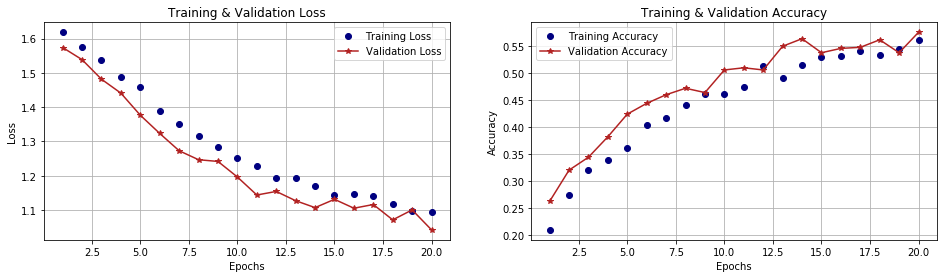

In [ ]:
# Visualize
show_plots(neural_ntwk1.history)

In [ ]:
# On Colab using GPU 

In [3]:
!ls '/content/drive/My Drive/dphi_bootcamp'

animal_names.npy			    ownModel_CNN_GPU.h5  x.npy
model_vgg_transferLearning_GPU100epochs.h5  test_images.npy	 y.npy


In [4]:
x = np.load('/content/drive/My Drive/dphi_bootcamp/x.npy')
y = np.load('/content/drive/My Drive/dphi_bootcamp/y.npy')
animal_names = np.load('/content/drive/My Drive/dphi_bootcamp/animal_names.npy')
test_images = np.load('/content/drive/My Drive/dphi_bootcamp/test_images.npy')


In [5]:
#Train val split
val_split_num = int(round(0.2*len(y)))

x_train = x[val_split_num:]
y_train = y[val_split_num:]

x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('#########TRAIN###############')
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('#########TEST###############')
print('x_test', x_test.shape)
print('y_test', y_test.shape)
print('############################')

# OneHotVectorizing categories
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train[:5])

# Input normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_train.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_train.shape)
print('image Shape:', x_train[0].shape)


#########TRAIN###############
x_train (2000, 224, 224, 3)
y_train (2000,)
#########TEST###############
x_test (500, 224, 224, 3)
y_test (500,)
############################
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
x_train Shape: (2000, 224, 224, 3) 	 x_test Shape: (2000, 224, 224, 3)
y_train Shape:  (2000, 5) 	 y_test Shape: (2000, 5)
image Shape: (224, 224, 3)


##  Now Let us define a suitable deep net. ( 3 VGG Block)


 * ConV filters = __16__ , __16__ and then __32__
 * Kernel  : (3,3)
 * Strides : (1,1)
 * Pool_size: (2,2)
 * Activation = __Relu__
 * Dropout : __30%__
 * Units : __256 Units__
 * output : __Softmax__ & __5__ classes.


In [ ]:
# Creating a Convolutional Neural Network using VGG16

# define input shape
INPUT_SHAPE = (224, 224, 3)
# or x_train[0].shape
epochs = 50
opt = optimizers.Adam()

loss = losses.SparseCategoricalCrossentropy(from_logits=True,
                        name='sparse_categorical_crossentropy')




In [ ]:
# define sequential model  With 3 CNN Layers
model2 = models.Sequential()

# define conv-pool layers - set 1
model2.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=x_train[0].shape))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model2.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 3
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model2.add(layers.Flatten())

# add dense layers with some dropout
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(rate=0.3))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(rate=0.3))

# add output layer
model2.add(layers.Dense(5, activation='softmax'))

In [ ]:
# compile model2
model2.compile(loss=loss,
              optimizer=opt,
              metrics=['accuracy'])
# view model layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 16)      2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)            

In [ ]:
# ImageDataGenerator for data augmentation 
train_data_gen = ImageDataGenerator(
                rotation_range=45, 
                width_shift_range=0.1,
                height_shift_range=0.1, 
                horizontal_flip=True)
train_data_gen.fit(x_train) 

In [ ]:
batch_size =32 
epochs = 50  
neural_ntwk2 = model2.fit_generator(
                    train_data_gen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/50
62/62 [==============================] - ETA: 2:44 - loss: 1.5279 - accuracy: 0.31 - ETA: 2:17 - loss: 1.4837 - accuracy: 0.37 - ETA: 2:07 - loss: 1.4723 - accuracy: 0.37 - ETA: 2:01 - loss: 1.4599 - accuracy: 0.39 - ETA: 1:57 - loss: 1.4302 - accuracy: 0.44 - ETA: 1:54 - loss: 1.4369 - accuracy: 0.43 - ETA: 1:51 - loss: 1.4363 - accuracy: 0.43 - ETA: 1:48 - loss: 1.4420 - accuracy: 0.42 - ETA: 1:46 - loss: 1.4423 - accuracy: 0.42 - ETA: 1:45 - loss: 1.4368 - accuracy: 0.43 - ETA: 1:42 - loss: 1.4412 - accuracy: 0.42 - ETA: 1:39 - loss: 1.4383 - accuracy: 0.44 - ETA: 1:37 - loss: 1.4451 - accuracy: 0.43 - ETA: 1:32 - loss: 1.4495 - accuracy: 0.43 - ETA: 1:30 - loss: 1.4452 - accuracy: 0.44 - ETA: 1:27 - loss: 1.4453 - accuracy: 0.44 - ETA: 1:25 - loss: 1.4440 - accuracy: 0.44 - ETA: 1:23 - loss: 1.4410 - accuracy: 0.45 - ETA: 1:21 - loss: 1.4438 - accuracy: 0.44 - ETA: 1:19 - loss: 1.4421 - accuracy: 0.44 - ETA: 1:17 - loss: 1.4390 - accuracy: 0.44 - ETA: 1:15 - loss: 1.4418

62/62 [==============================] - ETA: 1:51 - loss: 1.4580 - accuracy: 0.43 - ETA: 1:49 - loss: 1.5228 - accuracy: 0.37 - ETA: 1:47 - loss: 1.5377 - accuracy: 0.35 - ETA: 1:49 - loss: 1.5331 - accuracy: 0.35 - ETA: 1:49 - loss: 1.5115 - accuracy: 0.38 - ETA: 1:48 - loss: 1.4980 - accuracy: 0.40 - ETA: 1:46 - loss: 1.4908 - accuracy: 0.40 - ETA: 1:45 - loss: 1.4885 - accuracy: 0.39 - ETA: 1:43 - loss: 1.4897 - accuracy: 0.39 - ETA: 1:41 - loss: 1.4859 - accuracy: 0.39 - ETA: 1:40 - loss: 1.4824 - accuracy: 0.40 - ETA: 1:38 - loss: 1.4823 - accuracy: 0.40 - ETA: 1:36 - loss: 1.4732 - accuracy: 0.41 - ETA: 1:34 - loss: 1.4765 - accuracy: 0.40 - ETA: 1:29 - loss: 1.4645 - accuracy: 0.41 - ETA: 1:28 - loss: 1.4660 - accuracy: 0.41 - ETA: 1:26 - loss: 1.4579 - accuracy: 0.42 - ETA: 1:24 - loss: 1.4662 - accuracy: 0.41 - ETA: 1:22 - loss: 1.4683 - accuracy: 0.41 - ETA: 1:20 - loss: 1.4684 - accuracy: 0.41 - ETA: 1:19 - loss: 1.4693 - accuracy: 0.41 - ETA: 1:17 - loss: 1.4688 - accuracy

62/62 [==============================] - ETA: 1:40 - loss: 1.2753 - accuracy: 0.68 - ETA: 1:38 - loss: 1.3511 - accuracy: 0.57 - ETA: 1:36 - loss: 1.3765 - accuracy: 0.53 - ETA: 1:36 - loss: 1.4089 - accuracy: 0.48 - ETA: 1:33 - loss: 1.3996 - accuracy: 0.48 - ETA: 1:32 - loss: 1.4182 - accuracy: 0.47 - ETA: 1:30 - loss: 1.4144 - accuracy: 0.48 - ETA: 1:30 - loss: 1.4019 - accuracy: 0.50 - ETA: 1:29 - loss: 1.3984 - accuracy: 0.50 - ETA: 1:28 - loss: 1.4002 - accuracy: 0.50 - ETA: 1:27 - loss: 1.4065 - accuracy: 0.49 - ETA: 1:26 - loss: 1.3994 - accuracy: 0.50 - ETA: 1:25 - loss: 1.3981 - accuracy: 0.50 - ETA: 1:24 - loss: 1.3971 - accuracy: 0.50 - ETA: 1:23 - loss: 1.3927 - accuracy: 0.51 - ETA: 1:22 - loss: 1.4042 - accuracy: 0.49 - ETA: 1:20 - loss: 1.4089 - accuracy: 0.48 - ETA: 1:19 - loss: 1.4029 - accuracy: 0.49 - ETA: 1:17 - loss: 1.3962 - accuracy: 0.50 - ETA: 1:16 - loss: 1.3890 - accuracy: 0.50 - ETA: 1:14 - loss: 1.3919 - accuracy: 0.50 - ETA: 1:13 - loss: 1.3924 - accuracy

62/62 [==============================] - ETA: 2:16 - loss: 1.5680 - accuracy: 0.34 - ETA: 2:04 - loss: 1.5579 - accuracy: 0.31 - ETA: 1:57 - loss: 1.4943 - accuracy: 0.38 - ETA: 1:54 - loss: 1.4964 - accuracy: 0.38 - ETA: 1:54 - loss: 1.4843 - accuracy: 0.39 - ETA: 1:55 - loss: 1.4981 - accuracy: 0.38 - ETA: 1:53 - loss: 1.4666 - accuracy: 0.41 - ETA: 1:52 - loss: 1.4458 - accuracy: 0.44 - ETA: 1:49 - loss: 1.4420 - accuracy: 0.44 - ETA: 1:45 - loss: 1.4191 - accuracy: 0.47 - ETA: 1:42 - loss: 1.4330 - accuracy: 0.45 - ETA: 1:39 - loss: 1.4227 - accuracy: 0.46 - ETA: 1:39 - loss: 1.4255 - accuracy: 0.46 - ETA: 1:39 - loss: 1.4313 - accuracy: 0.45 - ETA: 1:37 - loss: 1.4204 - accuracy: 0.46 - ETA: 1:34 - loss: 1.4263 - accuracy: 0.46 - ETA: 1:32 - loss: 1.4214 - accuracy: 0.46 - ETA: 1:29 - loss: 1.4165 - accuracy: 0.47 - ETA: 1:27 - loss: 1.4151 - accuracy: 0.47 - ETA: 1:25 - loss: 1.4131 - accuracy: 0.47 - ETA: 1:24 - loss: 1.4131 - accuracy: 0.47 - ETA: 1:22 - loss: 1.4090 - accuracy

62/62 [==============================] - ETA: 1:54 - loss: 1.3830 - accuracy: 0.53 - ETA: 1:52 - loss: 1.3789 - accuracy: 0.53 - ETA: 1:52 - loss: 1.4111 - accuracy: 0.47 - ETA: 1:54 - loss: 1.3750 - accuracy: 0.51 - ETA: 2:01 - loss: 1.3782 - accuracy: 0.51 - ETA: 2:01 - loss: 1.3817 - accuracy: 0.51 - ETA: 1:58 - loss: 1.3879 - accuracy: 0.50 - ETA: 1:55 - loss: 1.3814 - accuracy: 0.51 - ETA: 1:51 - loss: 1.3612 - accuracy: 0.53 - ETA: 1:48 - loss: 1.3553 - accuracy: 0.54 - ETA: 1:45 - loss: 1.3474 - accuracy: 0.54 - ETA: 1:41 - loss: 1.3603 - accuracy: 0.53 - ETA: 1:38 - loss: 1.3523 - accuracy: 0.54 - ETA: 1:36 - loss: 1.3564 - accuracy: 0.54 - ETA: 1:34 - loss: 1.3633 - accuracy: 0.53 - ETA: 1:32 - loss: 1.3613 - accuracy: 0.53 - ETA: 1:30 - loss: 1.3617 - accuracy: 0.53 - ETA: 1:28 - loss: 1.3643 - accuracy: 0.53 - ETA: 1:26 - loss: 1.3613 - accuracy: 0.53 - ETA: 1:24 - loss: 1.3540 - accuracy: 0.54 - ETA: 1:22 - loss: 1.3551 - accuracy: 0.54 - ETA: 1:20 - loss: 1.3504 - accuracy

62/62 [==============================] - ETA: 2:07 - loss: 1.3417 - accuracy: 0.50 - ETA: 1:58 - loss: 1.3286 - accuracy: 0.57 - ETA: 1:51 - loss: 1.3172 - accuracy: 0.58 - ETA: 1:50 - loss: 1.3177 - accuracy: 0.57 - ETA: 1:49 - loss: 1.3226 - accuracy: 0.57 - ETA: 1:47 - loss: 1.3303 - accuracy: 0.56 - ETA: 1:43 - loss: 1.3291 - accuracy: 0.56 - ETA: 1:40 - loss: 1.3482 - accuracy: 0.54 - ETA: 1:39 - loss: 1.3650 - accuracy: 0.52 - ETA: 1:36 - loss: 1.3850 - accuracy: 0.50 - ETA: 1:32 - loss: 1.3838 - accuracy: 0.51 - ETA: 1:30 - loss: 1.3830 - accuracy: 0.51 - ETA: 1:28 - loss: 1.3906 - accuracy: 0.50 - ETA: 1:26 - loss: 1.3890 - accuracy: 0.50 - ETA: 1:23 - loss: 1.3873 - accuracy: 0.51 - ETA: 1:21 - loss: 1.3854 - accuracy: 0.51 - ETA: 1:19 - loss: 1.3852 - accuracy: 0.51 - ETA: 1:17 - loss: 1.3810 - accuracy: 0.52 - ETA: 1:15 - loss: 1.3820 - accuracy: 0.51 - ETA: 1:13 - loss: 1.3799 - accuracy: 0.52 - ETA: 1:12 - loss: 1.3759 - accuracy: 0.52 - ETA: 1:11 - loss: 1.3690 - accuracy

62/62 [==============================] - ETA: 1:52 - loss: 1.2861 - accuracy: 0.65 - ETA: 1:39 - loss: 1.3185 - accuracy: 0.57 - ETA: 1:33 - loss: 1.3002 - accuracy: 0.59 - ETA: 1:28 - loss: 1.3254 - accuracy: 0.57 - ETA: 1:24 - loss: 1.3472 - accuracy: 0.54 - ETA: 1:21 - loss: 1.3567 - accuracy: 0.53 - ETA: 1:21 - loss: 1.3549 - accuracy: 0.54 - ETA: 1:19 - loss: 1.3455 - accuracy: 0.55 - ETA: 1:19 - loss: 1.3509 - accuracy: 0.54 - ETA: 1:18 - loss: 1.3478 - accuracy: 0.54 - ETA: 1:16 - loss: 1.3410 - accuracy: 0.55 - ETA: 1:17 - loss: 1.3364 - accuracy: 0.56 - ETA: 1:16 - loss: 1.3374 - accuracy: 0.56 - ETA: 1:14 - loss: 1.3483 - accuracy: 0.54 - ETA: 1:12 - loss: 1.3462 - accuracy: 0.55 - ETA: 1:11 - loss: 1.3475 - accuracy: 0.54 - ETA: 1:09 - loss: 1.3431 - accuracy: 0.55 - ETA: 1:07 - loss: 1.3473 - accuracy: 0.54 - ETA: 1:05 - loss: 1.3518 - accuracy: 0.54 - ETA: 1:03 - loss: 1.3512 - accuracy: 0.55 - ETA: 1:02 - loss: 1.3550 - accuracy: 0.54 - ETA: 1:01 - loss: 1.3532 - accuracy

62/62 [==============================] - ETA: 1:33 - loss: 1.4260 - accuracy: 0.46 - ETA: 1:31 - loss: 1.3594 - accuracy: 0.53 - ETA: 1:29 - loss: 1.3703 - accuracy: 0.52 - ETA: 1:27 - loss: 1.3826 - accuracy: 0.50 - ETA: 1:27 - loss: 1.3926 - accuracy: 0.50 - ETA: 1:27 - loss: 1.3881 - accuracy: 0.50 - ETA: 1:27 - loss: 1.3848 - accuracy: 0.50 - ETA: 1:27 - loss: 1.3833 - accuracy: 0.51 - ETA: 1:26 - loss: 1.3927 - accuracy: 0.50 - ETA: 1:26 - loss: 1.4053 - accuracy: 0.49 - ETA: 1:26 - loss: 1.3933 - accuracy: 0.50 - ETA: 1:24 - loss: 1.3844 - accuracy: 0.51 - ETA: 1:22 - loss: 1.3776 - accuracy: 0.51 - ETA: 1:20 - loss: 1.3806 - accuracy: 0.51 - ETA: 1:18 - loss: 1.3753 - accuracy: 0.52 - ETA: 1:17 - loss: 1.3752 - accuracy: 0.52 - ETA: 1:15 - loss: 1.3675 - accuracy: 0.53 - ETA: 1:12 - loss: 1.3715 - accuracy: 0.52 - ETA: 1:10 - loss: 1.3729 - accuracy: 0.52 - ETA: 1:08 - loss: 1.3669 - accuracy: 0.53 - ETA: 1:06 - loss: 1.3676 - accuracy: 0.53 - ETA: 1:05 - loss: 1.3667 - accuracy

62/62 [==============================] - ETA: 1:36 - loss: 1.3745 - accuracy: 0.53 - ETA: 1:28 - loss: 1.3203 - accuracy: 0.56 - ETA: 1:41 - loss: 1.3445 - accuracy: 0.54 - ETA: 1:43 - loss: 1.3526 - accuracy: 0.53 - ETA: 1:38 - loss: 1.3674 - accuracy: 0.52 - ETA: 1:34 - loss: 1.3732 - accuracy: 0.52 - ETA: 1:33 - loss: 1.3666 - accuracy: 0.52 - ETA: 1:30 - loss: 1.3595 - accuracy: 0.52 - ETA: 1:28 - loss: 1.3482 - accuracy: 0.54 - ETA: 1:25 - loss: 1.3494 - accuracy: 0.54 - ETA: 1:23 - loss: 1.3541 - accuracy: 0.53 - ETA: 1:20 - loss: 1.3459 - accuracy: 0.54 - ETA: 1:18 - loss: 1.3428 - accuracy: 0.54 - ETA: 1:17 - loss: 1.3402 - accuracy: 0.55 - ETA: 1:15 - loss: 1.3376 - accuracy: 0.55 - ETA: 1:14 - loss: 1.3378 - accuracy: 0.55 - ETA: 1:12 - loss: 1.3419 - accuracy: 0.54 - ETA: 1:10 - loss: 1.3434 - accuracy: 0.54 - ETA: 1:08 - loss: 1.3457 - accuracy: 0.54 - ETA: 1:06 - loss: 1.3462 - accuracy: 0.54 - ETA: 1:04 - loss: 1.3416 - accuracy: 0.54 - ETA: 1:02 - loss: 1.3413 - accuracy

62/62 [==============================] - ETA: 54s - loss: 1.5088 - accuracy: 0.375 - ETA: 1:14 - loss: 1.4773 - accuracy: 0.43 - ETA: 1:19 - loss: 1.4162 - accuracy: 0.51 - ETA: 1:21 - loss: 1.3902 - accuracy: 0.52 - ETA: 1:22 - loss: 1.3924 - accuracy: 0.52 - ETA: 1:21 - loss: 1.3582 - accuracy: 0.56 - ETA: 1:20 - loss: 1.3594 - accuracy: 0.55 - ETA: 1:25 - loss: 1.3474 - accuracy: 0.56 - ETA: 1:23 - loss: 1.3558 - accuracy: 0.55 - ETA: 1:21 - loss: 1.3494 - accuracy: 0.56 - ETA: 1:19 - loss: 1.3409 - accuracy: 0.57 - ETA: 1:19 - loss: 1.3491 - accuracy: 0.56 - ETA: 1:17 - loss: 1.3363 - accuracy: 0.57 - ETA: 1:16 - loss: 1.3313 - accuracy: 0.58 - ETA: 1:15 - loss: 1.3320 - accuracy: 0.57 - ETA: 1:14 - loss: 1.3298 - accuracy: 0.58 - ETA: 1:12 - loss: 1.3319 - accuracy: 0.57 - ETA: 1:11 - loss: 1.3375 - accuracy: 0.57 - ETA: 1:10 - loss: 1.3414 - accuracy: 0.56 - ETA: 1:08 - loss: 1.3413 - accuracy: 0.56 - ETA: 1:07 - loss: 1.3415 - accuracy: 0.56 - ETA: 1:06 - loss: 1.3372 - accuracy

62/62 [==============================] - ETA: 1:37 - loss: 1.3662 - accuracy: 0.50 - ETA: 1:36 - loss: 1.3935 - accuracy: 0.46 - ETA: 1:32 - loss: 1.3129 - accuracy: 0.56 - ETA: 1:28 - loss: 1.3267 - accuracy: 0.56 - ETA: 1:25 - loss: 1.3185 - accuracy: 0.57 - ETA: 1:23 - loss: 1.3012 - accuracy: 0.59 - ETA: 1:21 - loss: 1.3108 - accuracy: 0.58 - ETA: 1:19 - loss: 1.3122 - accuracy: 0.58 - ETA: 1:17 - loss: 1.3156 - accuracy: 0.57 - ETA: 1:17 - loss: 1.3155 - accuracy: 0.58 - ETA: 1:16 - loss: 1.3036 - accuracy: 0.59 - ETA: 1:14 - loss: 1.2967 - accuracy: 0.60 - ETA: 1:13 - loss: 1.2973 - accuracy: 0.60 - ETA: 1:12 - loss: 1.2995 - accuracy: 0.60 - ETA: 1:10 - loss: 1.3057 - accuracy: 0.59 - ETA: 1:09 - loss: 1.3163 - accuracy: 0.58 - ETA: 1:08 - loss: 1.3254 - accuracy: 0.57 - ETA: 1:07 - loss: 1.3333 - accuracy: 0.56 - ETA: 1:05 - loss: 1.3387 - accuracy: 0.56 - ETA: 1:04 - loss: 1.3360 - accuracy: 0.56 - ETA: 1:02 - loss: 1.3345 - accuracy: 0.56 - ETA: 1:01 - loss: 1.3371 - accuracy

62/62 [==============================] - ETA: 1:32 - loss: 1.4017 - accuracy: 0.46 - ETA: 1:32 - loss: 1.3545 - accuracy: 0.51 - ETA: 1:28 - loss: 1.3482 - accuracy: 0.54 - ETA: 1:26 - loss: 1.3226 - accuracy: 0.57 - ETA: 1:25 - loss: 1.3116 - accuracy: 0.58 - ETA: 1:25 - loss: 1.3146 - accuracy: 0.58 - ETA: 1:24 - loss: 1.3266 - accuracy: 0.57 - ETA: 1:25 - loss: 1.3266 - accuracy: 0.57 - ETA: 1:25 - loss: 1.3498 - accuracy: 0.54 - ETA: 1:24 - loss: 1.3386 - accuracy: 0.55 - ETA: 1:23 - loss: 1.3424 - accuracy: 0.55 - ETA: 1:21 - loss: 1.3414 - accuracy: 0.55 - ETA: 1:19 - loss: 1.3438 - accuracy: 0.55 - ETA: 1:16 - loss: 1.3423 - accuracy: 0.55 - ETA: 1:14 - loss: 1.3441 - accuracy: 0.55 - ETA: 1:13 - loss: 1.3471 - accuracy: 0.55 - ETA: 1:11 - loss: 1.3365 - accuracy: 0.56 - ETA: 1:09 - loss: 1.3309 - accuracy: 0.57 - ETA: 1:08 - loss: 1.3280 - accuracy: 0.57 - ETA: 1:06 - loss: 1.3209 - accuracy: 0.58 - ETA: 1:05 - loss: 1.3137 - accuracy: 0.58 - ETA: 1:03 - loss: 1.3164 - accuracy

62/62 [==============================] - ETA: 1:37 - loss: 1.2630 - accuracy: 0.65 - ETA: 1:36 - loss: 1.3644 - accuracy: 0.54 - ETA: 1:35 - loss: 1.3996 - accuracy: 0.50 - ETA: 1:34 - loss: 1.3703 - accuracy: 0.53 - ETA: 1:32 - loss: 1.3539 - accuracy: 0.55 - ETA: 1:28 - loss: 1.3277 - accuracy: 0.57 - ETA: 1:27 - loss: 1.3235 - accuracy: 0.58 - ETA: 1:25 - loss: 1.3306 - accuracy: 0.58 - ETA: 1:23 - loss: 1.3167 - accuracy: 0.59 - ETA: 1:21 - loss: 1.3233 - accuracy: 0.58 - ETA: 1:19 - loss: 1.3305 - accuracy: 0.57 - ETA: 1:18 - loss: 1.3240 - accuracy: 0.58 - ETA: 1:17 - loss: 1.3337 - accuracy: 0.57 - ETA: 1:15 - loss: 1.3346 - accuracy: 0.56 - ETA: 1:13 - loss: 1.3348 - accuracy: 0.56 - ETA: 1:16 - loss: 1.3420 - accuracy: 0.56 - ETA: 1:15 - loss: 1.3478 - accuracy: 0.55 - ETA: 1:14 - loss: 1.3396 - accuracy: 0.56 - ETA: 1:12 - loss: 1.3486 - accuracy: 0.55 - ETA: 1:10 - loss: 1.3475 - accuracy: 0.55 - ETA: 1:08 - loss: 1.3537 - accuracy: 0.54 - ETA: 1:05 - loss: 1.3545 - accuracy

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
    epochs,neural_ntwk2.history['accuracy'][epochs-1],neural_ntwk2.history['val_accuracy'][epochs-1]))


CNN: Epochs=50, Train accuracy=0.56552, Validation accuracy=0.64200


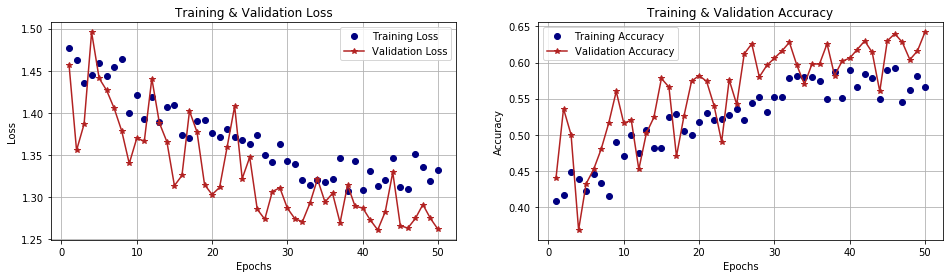

In [ ]:
# Visualize
show_plots(neural_ntwk2.history)

In [ ]:
## Testiing 

In [ ]:
# Predicting Categories for Test Data
test_prediction = model2.predict(test_images)

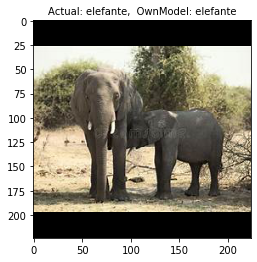

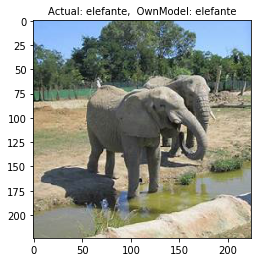

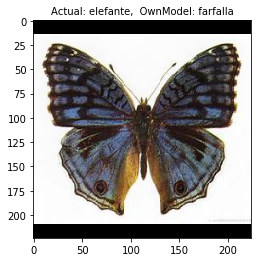

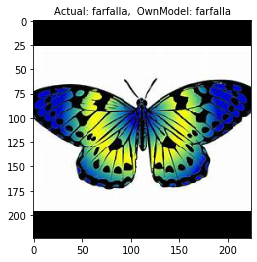

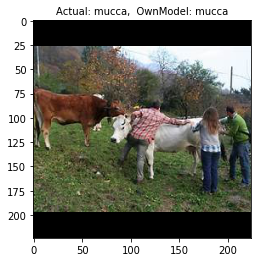

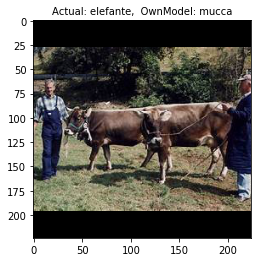

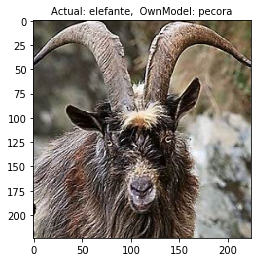

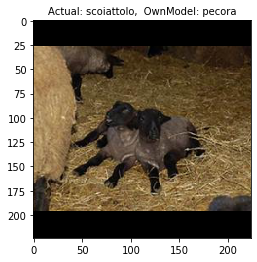

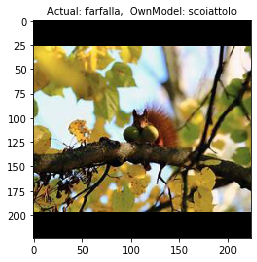

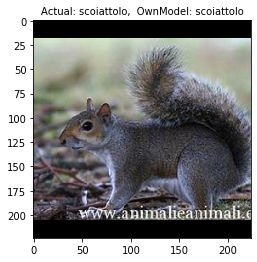

In [ ]:
# should run above first......
actual_pred['category']=actual_pred['category'].astype('int')
for i in range(10):
    predict1= test_prediction[i].argmax()
    actual=actual_pred['category'][i]
    plt.imshow(test_images[i])
    plt.title("Actual: {1},  OwnModel: {0}".format((animal_names[actual]),(animal_names[predict1])), fontsize=10)
    plt.show()

In [ ]:
# saving the model
save_dir = "C:/jupyter/Dphi_bootCamp/Assignement2/res_models/"
model_name = 'ownModel_CNN_3layers.h5'
model_path = save_dir + model_name
model2.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:/jupyter/Dphi_bootCamp/Assignement2/res_models/ownModel_CNN_3layers.h5 


In [ ]:
# Test Model2 on test images

In [ ]:
test_data = pd.read_csv('Testing_set_animals.csv')

In [ ]:
test_data.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,NaN
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,NaN
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,NaN
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,NaN
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,NaN


In [ ]:
tst = test_data.copy()

In [ ]:
tst['filename'] = './test/' + tst['filename']

In [ ]:
tst.head()

,filename,target
0,./test/e030b20928e90021d85a5854ee454296eb70e3c...,NaN
1,./test/e030b20929e90021d85a5854ee454296eb70e3c...,NaN
2,./test/e030b2092be90021d85a5854ee454296eb70e3c...,NaN
3,./test/e030b2092ce90021d85a5854ee454296eb70e3c...,NaN
4,./test/e030b2092de90021d85a5854ee454296eb70e3c...,NaN


In [ ]:
tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  910 non-null    object 
 1   target    0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 14.3+ KB


In [ ]:
# Image Resizing and converting them to array for test images of folder test
""" 
TQDM is a progress bar library. 
Inserting tqdm (or python -m tqdm)between pipes will pass 
through all stdin to stdout while printing progress to stderr
"""
tst_images = []
with tqdm(total=len(tst)) as pbar:
    for i, file_path in enumerate(tst.filename.values):
        
        #read image
        img = cv2.imread(file_path,1)
        #color order is changed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        tst_images.append(img)
        pbar.update(1)

tst_images = np.array(tst_images)
tst_images = tst_images/255

In [ ]:
tst_images.shape


(910, 224, 224, 3)

In [ ]:
target_prediction = model2.predict(tst_images)

In [ ]:
target_prediction[1]

array([1.3381704e-09, 9.8763198e-01, 1.8394596e-07, 1.2284703e-02,
       8.3194944e-05], dtype=float32)

In [ ]:
res_target1 = []
real_names = []
for i in range(0,910):
    res_target1.append(np.argmax(target_prediction[i]))
    real_names.append(str("'")+animal_names[np.argmax(target_prediction[i])]+str("'"))
    

In [ ]:
real_names[1]

"'farfalla'"

In [ ]:
final_pd = pd.DataFrame(real_names)

In [ ]:
final_pd.head()

,0
0,'elefante'
1,'farfalla'
2,'pecora'
3,'pecora'
4,'scoiattolo'


In [ ]:
final_pd = final_pd.astype(str)

In [ ]:
final_pd.index= tst.index

In [ ]:
final_pd.columns= ['target']

In [ ]:
final_pd.head()

,target
0,'elefante'
1,'farfalla'
2,'pecora'
3,'pecora'
4,'scoiattolo'


In [ ]:
final_pd.to_csv("pred_class5_animals_modelCNN_3layers.csv",index=False, header=False)

In [ ]:
# Accuracy : 61.868132 on unseen data of test folder. (Via Dphi Score)

In [ ]:
test_loss, test_acc = model2.evaluate(x_test,  y_test, verbose=2)
print(test_acc) # x_test and y_test are from the split 

500/1 - 6s - loss: 1.2925 - accuracy: 0.6420
0.642


##  Now Let us define a suitable deep net. ( 3 VGG Block)


* In the first stage, Our net will learn 32 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape, so it will be 32 x 32 and activation is relu, which is a simple way of introducing non-linearity; folowed by another 32 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 20%.


* In the next stage in the deep pipeline, Our net will learn 64 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape and activation is relu; folowed by another 64 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 20%.


* In the next stage in the deep pipeline, Our net will learn 128 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape and activation is relu; folowed by another 128 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 20%.


* And the Final stage in the deep pipeline is a dense network with 128 units and relu activation followed by a dropout at 20% and by a softmax layer with 5 classes as output, one for each category.


 * ConV filters = __32*32__ , __64*64__ and then __128*128__
 * Kernel  : (3,3)
 * Pool_size: (2,2)
 * Activation = __Relu__
 * Dropout : __20%__
 * Units : __128 Units__
 * output : __Softmax__ & __5__ classes.


In [8]:
# Params 

# define input shape
INPUT_SHAPE = (224, 224, 3)
# SGD Params
epochs = 100
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.9
sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

In [9]:
# Creating a Convolutional Neural Network using 3 blocs of VGG
model3 = models.Sequential()
# Input layer

# CNN > CNN > Pool > Dropout
model3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=INPUT_SHAPE))
model3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))

# CNN > CNN > Pool > Dropout
model3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))

# CNN > CNN > Pool > Dropout
model3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))

# Flatten
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(layers.Dropout(0.2))

#output layer
model3.add(layers.Dense(5, activation='softmax'))

In [10]:
# compile model2
model3.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer=sgd,
              metrics=['accuracy'])
# view model layers
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)       

In [ ]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(
                rotation_range=45, 
                width_shift_range=0.1,
                height_shift_range=0.1, 
                horizontal_flip=True)
train_data_gen.fit(x_train) 

batch_size =32 
epochs = 100  
neural_ntwk3_gpu = model3.fit_generator(
                    train_data_gen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/100
62/62 [==============================] - 23s 363ms/step - loss: 1.6383 - accuracy: 0.2302 - val_loss: 1.5773 - val_accuracy: 0.2960
Epoch 2/100
62/62 [==============================] - 22s 355ms/step - loss: 1.5924 - accuracy: 0.2785 - val_loss: 1.5541 - val_accuracy: 0.3360
Epoch 3/100
62/62 [==============================] - 22s 353ms/step - loss: 1.5684 - accuracy: 0.2881 - val_loss: 1.5408 - val_accuracy: 0.3620
Epoch 4/100
62/62 [==============================] - 22s 353ms/step - loss: 1.5333 - accuracy: 0.3435 - val_loss: 1.5135 - val_accuracy: 0.3940
Epoch 5/100
62/62 [==============================] - 22s 358ms/step - loss: 1.5318 - accuracy: 0.3298 - val_loss: 1.5032 - val_accuracy: 0.3920
Epoch 6/100
62/62 [==============================] - 22s 358ms/step - loss: 1.4986 - accuracy: 0.3847 - val_loss: 1.4781 - val_accuracy: 0.4040
Epoch 7/100
62/62 [==============================] - 22s 355ms/step - loss: 1.5014 - accuracy: 0.3735 - val_loss: 1.4860 - val_accuracy:

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
    epochs,neural_ntwk3_gpu.history['accuracy'][epochs-1],neural_ntwk3_gpu.history['val_accuracy'][epochs-1]))


CNN: Epochs=100, Train accuracy=0.64380, Validation accuracy=0.65200


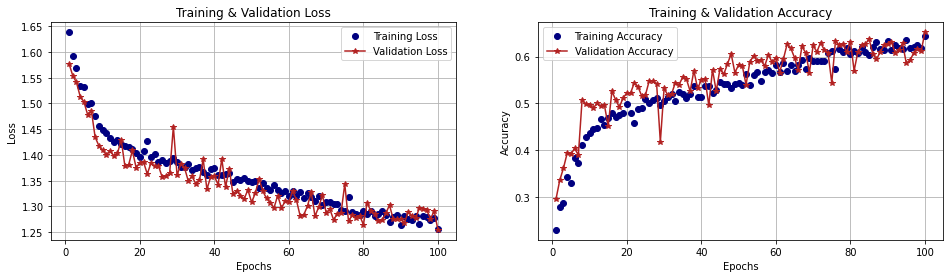

In [ ]:
# Visualize
show_plots(neural_ntwk3_gpu.history)

In [ ]:
# saving the model
save_dir = "/content/drive/My Drive/dphi_bootcamp/"
model_name = 'ownModel_CNN_GPU.h5'
model_path = save_dir + model_name
model3.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/dphi_bootcamp/ownModel_CNN_GPU.h5 


##  Now Let us define a suitable deep net. ( 3 VGG Block)

 * ConV filters = __16__ , __16__ and then __32__
 * Kernel  : (3,3)
 * Strides : (1,1)
 * Pool_size: (2,2)
 * Activation = __Relu__
 * Dropout : __30%__
 * Units : __256 * 256 Units__
 * output : __Softmax__ & __5__ classes.


In [22]:
# define sequential model  With 3 VGG Block
model4 = models.Sequential()

# define conv-pool layers - set 1
model4.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=x_train[0].shape))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 2
model4.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 3
model4.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model4.add(layers.Flatten())

# add dense layers with some dropout
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dropout(rate=0.3))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dropout(rate=0.3))

# add output layer
model4.add(layers.Dense(5, activation='softmax'))



# compile model2
model4.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
# view model layers
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)            

In [23]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(
                rotation_range=45, 
                width_shift_range=0.1,
                height_shift_range=0.1, 
                horizontal_flip=True)
train_data_gen.fit(x_train) 

In [24]:
# ImageDataGenerator for data augmentation 
batch_size = 32 
epochs = 150  
neural_ntwk4_gpu100epochs = model4.fit_generator(
                    train_data_gen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose= 1)

Epoch 1/150
62/62 [==============================] - 23s 374ms/step - loss: 1.5845 - accuracy: 0.2282 - val_loss: 1.5212 - val_accuracy: 0.3020
Epoch 2/150
62/62 [==============================] - 23s 364ms/step - loss: 1.5013 - accuracy: 0.3572 - val_loss: 1.4310 - val_accuracy: 0.4700
Epoch 3/150
62/62 [==============================] - 22s 363ms/step - loss: 1.4560 - accuracy: 0.4380 - val_loss: 1.4036 - val_accuracy: 0.4760
Epoch 4/150
62/62 [==============================] - 22s 358ms/step - loss: 1.4414 - accuracy: 0.4365 - val_loss: 1.3804 - val_accuracy: 0.5080
Epoch 5/150
62/62 [==============================] - 22s 361ms/step - loss: 1.4270 - accuracy: 0.4675 - val_loss: 1.4369 - val_accuracy: 0.4560
Epoch 6/150
62/62 [==============================] - 22s 358ms/step - loss: 1.4386 - accuracy: 0.4507 - val_loss: 1.4534 - val_accuracy: 0.4460
Epoch 7/150
62/62 [==============================] - 22s 360ms/step - loss: 1.4422 - accuracy: 0.4436 - val_loss: 1.3850 - val_accuracy:

In [25]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
    epochs,neural_ntwk4_gpu100epochs.history['accuracy'][epochs-1],neural_ntwk4_gpu100epochs.history['val_accuracy'][epochs-1]))


CNN: Epochs=150, Train accuracy=0.66057, Validation accuracy=0.71800


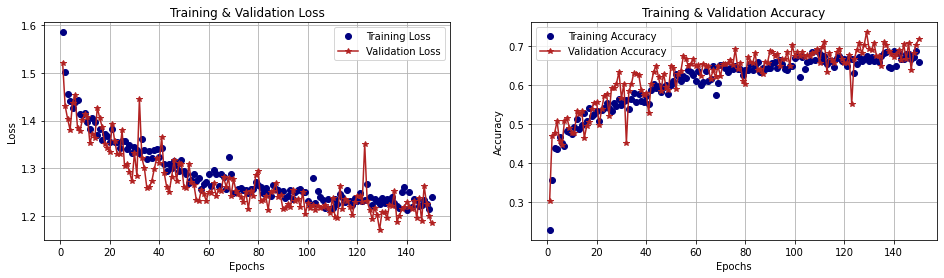

In [28]:
# Visualize 
show_plots(neural_ntwk4_gpu100epochs.history)

In [29]:
# saving the model
save_dir = "/content/drive/My Drive/dphi_bootcamp/"
model_name = 'ownModel_3VGG_CNN_GPU150epochs.h5'
model_path = save_dir + model_name
model4.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/dphi_bootcamp/ownModel_3VGG_CNN_GPU150epochs.h5 
